In [1]:
!nvidia-smi

Tue Mar 25 03:56:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## VQVAE LISTA

Using device: cuda
Loading dataset...
Initializing model with fixed sparsity level k=5...


Epoch 1/10: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s, loss=0.0177, recon=0.0097, commit=0.0067, sparsity=0.0268, psnr=20.1488]



====> Epoch: 1 Average loss: 0.0981, Recon: 0.0415, Commit: 0.0471, Sparsity: 0.1885, PSNR:  18.0384


Epoch 2/10: 100%|██████████| 391/391 [00:11<00:00, 34.04it/s, loss=0.0103, recon=0.0064, commit=0.0033, sparsity=0.0133, psnr=21.9683]



====> Epoch: 2 Average loss: 0.0120, Recon: 0.0069, Commit: 0.0043, Sparsity: 0.0170, PSNR:  21.6150


Epoch 3/10: 100%|██████████| 391/391 [00:11<00:00, 35.04it/s, loss=0.0074, recon=0.0049, commit=0.0021, sparsity=0.0083, psnr=23.1160]



====> Epoch: 3 Average loss: 0.0083, Recon: 0.0055, Commit: 0.0023, Sparsity: 0.0093, PSNR:  22.6371


Epoch 4/10: 100%|██████████| 391/391 [00:10<00:00, 36.28it/s, loss=0.0064, recon=0.0045, commit=0.0016, sparsity=0.0063, psnr=23.4258]



====> Epoch: 4 Average loss: 0.0069, Recon: 0.0048, Commit: 0.0017, Sparsity: 0.0069, PSNR:  23.1653


Epoch 5/10: 100%|██████████| 391/391 [00:10<00:00, 36.99it/s, loss=0.0065, recon=0.0047, commit=0.0015, sparsity=0.0059, psnr=23.2570]



====> Epoch: 5 Average loss: 0.0062, Recon: 0.0044, Commit: 0.0015, Sparsity: 0.0060, PSNR:  23.5593


Epoch 6/10: 100%|██████████| 391/391 [00:10<00:00, 37.03it/s, loss=0.0072, recon=0.0056, commit=0.0014, sparsity=0.0055, psnr=22.5282]



====> Epoch: 6 Average loss: 0.0058, Recon: 0.0041, Commit: 0.0014, Sparsity: 0.0057, PSNR:  23.8630


Epoch 7/10: 100%|██████████| 391/391 [00:10<00:00, 37.49it/s, loss=0.0057, recon=0.0037, commit=0.0016, sparsity=0.0066, psnr=24.3094]



====> Epoch: 7 Average loss: 0.0057, Recon: 0.0039, Commit: 0.0015, Sparsity: 0.0060, PSNR:  24.1474


Epoch 8/10: 100%|██████████| 391/391 [00:10<00:00, 37.86it/s, loss=0.0053, recon=0.0036, commit=0.0014, sparsity=0.0057, psnr=24.3960]



====> Epoch: 8 Average loss: 0.0054, Recon: 0.0037, Commit: 0.0014, Sparsity: 0.0057, PSNR:  24.3720


Epoch 9/10: 100%|██████████| 391/391 [00:10<00:00, 37.18it/s, loss=0.0042, recon=0.0029, commit=0.0010, sparsity=0.0040, psnr=25.3058]



====> Epoch: 9 Average loss: 0.0048, Recon: 0.0034, Commit: 0.0012, Sparsity: 0.0048, PSNR:  24.7300


Epoch 10/10: 100%|██████████| 391/391 [00:10<00:00, 37.35it/s, loss=0.0037, recon=0.0027, commit=0.0009, sparsity=0.0036, psnr=25.7383]


====> Epoch: 10 Average loss: 0.0044, Recon: 0.0032, Commit: 0.0010, Sparsity: 0.0041, PSNR:  24.9975

Generating reconstructions...


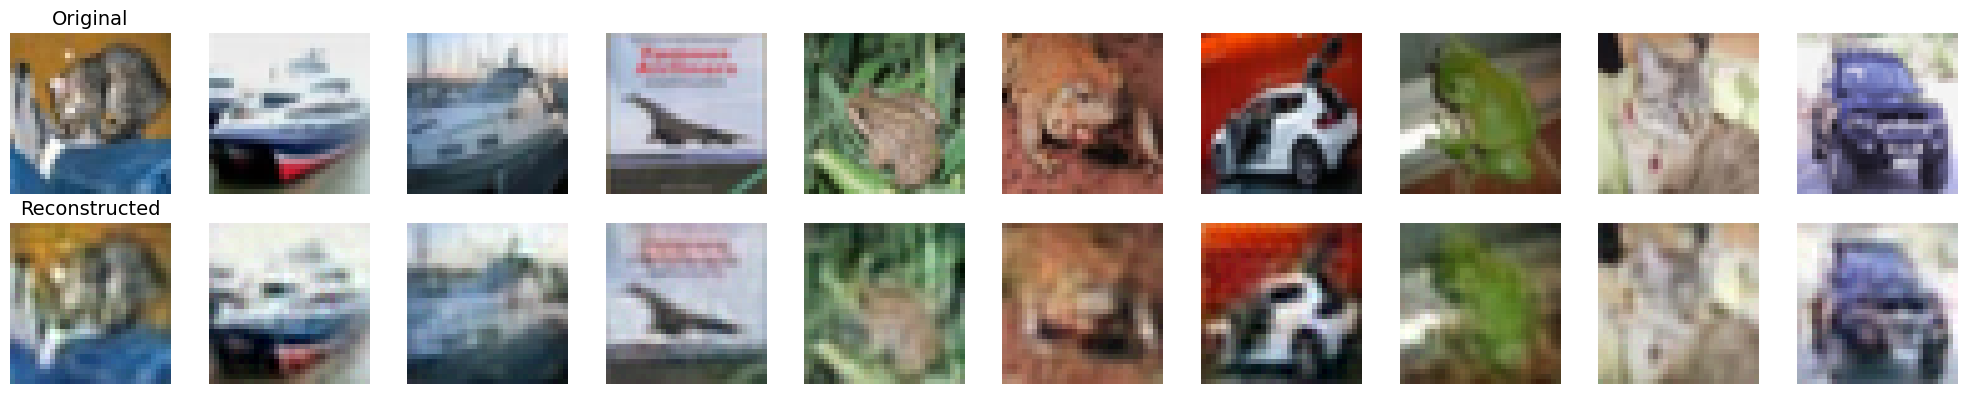


Visualizing dictionary atoms...


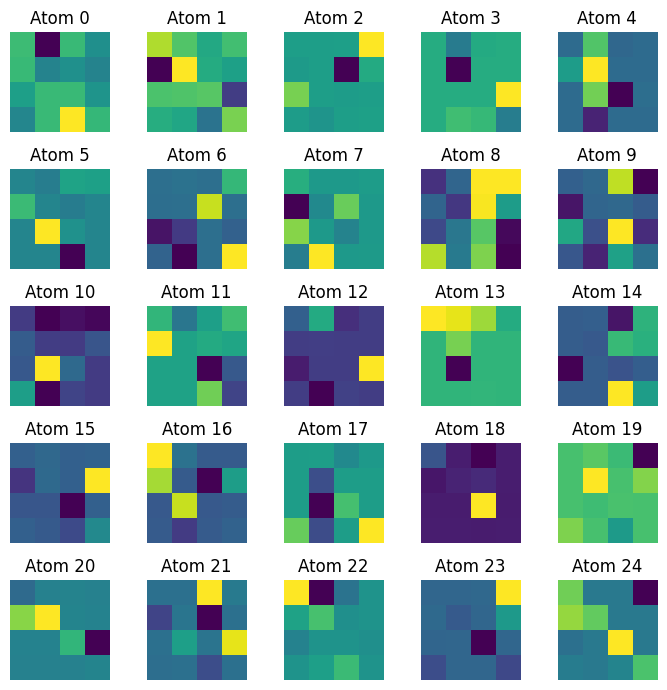

Saving model...
Training complete!


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

class LISTA(nn.Module):
    """
    Learned Iterative Shrinkage-Thresholding Algorithm (LISTA) module for sparse coding.
    """
    def __init__(self, input_dim, code_dim, num_iterations=10, k_sparse=5):
        super(LISTA, self).__init__()

        self.input_dim = input_dim
        self.code_dim = code_dim
        self.num_iterations = num_iterations
        self.k_sparse = k_sparse  # Fixed sparsity level (k)

        # Initialize LISTA parameters with careful scaling
        self.W = nn.Parameter(torch.randn(code_dim, input_dim) * 0.01)
        self.S = nn.Parameter(torch.randn(code_dim, code_dim) * 0.01)

        # Initialize shrinkage parameter
        self.theta = nn.Parameter(torch.ones(code_dim) * 0.1)

        # Apply spectral normalization to S to ensure stability
        with torch.no_grad():
            # Ensure the eigenvalues of S are less than 1 for convergence
            u, s, v = torch.svd(self.S.data)
            self.S.data = self.S.data * 0.9 / s.max()

    def soft_threshold(self, x, threshold):
        """Soft thresholding operator: sign(x) * max(|x| - threshold, 0)"""
        return torch.sign(x) * F.relu(torch.abs(x) - threshold.unsqueeze(0))

    def k_sparse_projection(self, x):
        """Keep only the k largest magnitude values in each row, set others to zero.
        This implementation guarantees exactly k non-zero values per sample."""
        batch_size = x.shape[0]
        code_dim = x.shape[1]
        k = min(self.k_sparse, code_dim)  # Ensure k is not larger than code_dim

        # Use topk operation which is faster than sorting
        _, indices = torch.topk(torch.abs(x), k=k, dim=1)

        # Create a new zero tensor and scatter the top-k values
        result = torch.zeros_like(x)
        batch_indices = torch.arange(batch_size, device=x.device).view(-1, 1).repeat(1, k)
        result.scatter_(1, indices, torch.gather(x, 1, indices))

        return result

    def forward(self, x):
        # Initialize sparse code
        batch_size = x.shape[0]
        alpha = torch.zeros(batch_size, self.code_dim, device=x.device)

        # LISTA iterations
        for i in range(self.num_iterations):
            # Update sparse code using LISTA update rule
            z = alpha @ self.S + x @ self.W.T

            # if i < self.num_iterations - 1:
            #     # Use soft thresholding for intermediate iterations
            #     alpha = self.soft_threshold(z, self.theta)
            # else:
            #     # For the final iteration, enforce exactly k-sparse representation
            #     alpha = self.k_sparse_projection(z)
            alpha = self.k_sparse_projection(z)

            # # Apply clipping to prevent numerical instability
            # alpha = torch.clamp(alpha, min=-100, max=100)

        return alpha


# class OnlineDictionary(nn.Module):
#     """
#     Online dictionary learning module.
#     """
#     def __init__(self, input_dim, dict_size, momentum=0.9):
#         super(OnlineDictionary, self).__init__()

#         self.input_dim = input_dim
#         self.dict_size = dict_size
#         self.momentum = momentum

#         # Initialize dictionary - each row is a dictionary atom
#         # Use small Gaussian initialization
#         self.D = nn.Parameter(torch.randn(dict_size, input_dim) * 0.01)
#         self._normalize_dictionary()

#     def _normalize_dictionary(self):
#         """Normalize each dictionary atom to have unit l2 norm."""
#         with torch.no_grad():
#             norms = torch.norm(self.D, dim=1, keepdim=True)
#             self.D.data = self.D.data / norms.clamp(min=1e-6)

#     def forward(self, x, alpha):
#         """
#         Reconstruct input using dictionary and sparse codes.

#         Args:
#             x: Original input for online dictionary update
#             alpha: Sparse codes from LISTA

#         Returns:
#             z_q: Reconstructed latent representation
#         """
#         # Reconstruction using sparse codes and dictionary
#         z_q = alpha @ self.D

#         # Clip to prevent numerical instability
#         # z_q = torch.clamp(z_q, min=-100, max=100)

#         # During training, update the dictionary (optional)
#         if self.training:
#             self._update_dictionary(x, alpha)

#         return z_q

#     def _update_dictionary(self, x, alpha):
#         """Online dictionary update using block coordinate descent."""
#         with torch.no_grad():
#             batch_size = alpha.shape[0]

#             # Compute error signal
#             error = x - alpha @ self.D

#             # Loop through each dictionary atom
#             for k in range(self.dict_size):
#                 # For atoms that are used in this batch
#                 mask = alpha[:, k] != 0
#                 if mask.sum() > 0:
#                     # Calculate the gradient for this atom
#                     a_k = alpha[mask, k].unsqueeze(1)
#                     e_k = error[mask] + a_k * self.D[k].unsqueeze(0)

#                     # Check for NaN/inf in a_k
#                     if torch.isnan(a_k).any() or torch.isinf(a_k).any():
#                         continue

#                     # Avoid division by zero or very large values
#                     count = mask.sum().clamp(min=1)
#                     grad = (a_k.T @ e_k) / count

#                     # Skip if gradient is NaN or infinity
#                     if torch.isnan(grad).any() or torch.isinf(grad).any():
#                         continue

#                     # Update dictionary atom with clipping for stability
#                     new_atom = self.momentum * self.D.data[k] + (1 - self.momentum) * grad.squeeze(0)

#                     # Skip if new atom contains NaN
#                     if not torch.isnan(new_atom).any() and not torch.isinf(new_atom).any():
#                         self.D.data[k] = new_atom

#             # Normalize dictionary
#             self._normalize_dictionary()


class OnlineDictionary(nn.Module):
    """
    Optimized online dictionary learning module.
    """
    def __init__(self, input_dim, dict_size, momentum=0.9, update_fraction=0.25):
        super(OnlineDictionary, self).__init__()

        self.input_dim = input_dim
        self.dict_size = dict_size
        self.momentum = momentum
        self.update_fraction = update_fraction  # Fraction of atoms to update per batch

        # Initialize dictionary - each row is a dictionary atom
        self.D = nn.Parameter(torch.randn(dict_size, input_dim) * 0.01)
        self._normalize_dictionary()

    def _normalize_dictionary(self):
        """Vectorized normalization of dictionary atoms."""
        with torch.no_grad():
            # Compute norms for all atoms at once
            norms = torch.norm(self.D, dim=1, keepdim=True)
            # Normalize all atoms at once
            self.D.data = self.D.data / norms.clamp(min=1e-6)

    def forward(self, x, alpha):
        """
        Reconstruct input using dictionary and sparse codes.

        Args:
            x: Original input for online dictionary update
            alpha: Sparse codes from LISTA

        Returns:
            z_q: Reconstructed latent representation
        """
        # Reconstruction using sparse codes and dictionary (unchanged)
        z_q = alpha @ self.D

        # Update dictionary during training
        if self.training:
            self._fast_dictionary_update(x, alpha)

        return z_q

    def _fast_dictionary_update(self, x, alpha):
        """Vectorized and optimized dictionary update."""
        with torch.no_grad():
            batch_size = alpha.shape[0]

            # Compute error signal
            error = x - alpha @ self.D

            # 1. Select atoms to update (stochastic updates)
            # Only update a fraction of atoms per batch to speed up training
            num_atoms_to_update = max(1, int(self.dict_size * self.update_fraction))
            atoms_to_update = torch.randperm(self.dict_size)[:num_atoms_to_update]

            # 2. Process these atoms efficiently in a vectorized manner
            for k in atoms_to_update:
                # Select samples where this atom is used (non-zero coefficient)
                mask = alpha[:, k] != 0
                if torch.sum(mask) > 0:
                    # Extract coefficients for this atom
                    a_k = alpha[mask, k].unsqueeze(1)

                    # Skip update if coefficients contain NaN or inf
                    if torch.isnan(a_k).any() or torch.isinf(a_k).any():
                        continue

                    # Compute the residual error for this atom
                    e_k = error[mask] + a_k * self.D[k].unsqueeze(0)

                    # Compute atom update using current samples
                    count = mask.sum().clamp(min=1)
                    grad = (a_k.T @ e_k) / count

                    # Skip if gradient is invalid
                    if torch.isnan(grad).any() or torch.isinf(grad).any():
                        continue

                    # Update atom with momentum
                    new_atom = self.momentum * self.D.data[k] + (1 - self.momentum) * grad.squeeze(0)

                    # Apply update if valid
                    if not torch.isnan(new_atom).any() and not torch.isinf(new_atom).any():
                        self.D.data[k] = new_atom

            # Normalize all dictionary atoms at once after updates
            self._normalize_dictionary()


class Encoder(nn.Module):
    """
    Encoder network for VQ-VAE.
    """
    def __init__(self, input_channels, hidden_dims, output_dim, input_size=32):
        super(Encoder, self).__init__()

        self.input_size = input_size
        layers = []
        in_channels = input_channels

        # Build encoder CNN layers
        for h_dim in hidden_dims:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, h_dim, kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.ReLU()
                )
            )
            in_channels = h_dim

        # Final layer to get to embedding dimension
        layers.append(
            nn.Conv2d(hidden_dims[-1], output_dim, kernel_size=1, stride=1)
        )

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        # Ensure input has correct dimensions
        if x.size(2) != self.input_size or x.size(3) != self.input_size:
            x = F.interpolate(x, size=(self.input_size, self.input_size), mode='bilinear', align_corners=False)
        z_e = self.encoder(x)
        return z_e


class Decoder(nn.Module):
    """
    Decoder network for VQ-VAE.
    """
    def __init__(self, input_dim, hidden_dims, output_channels, output_size=32):
        super(Decoder, self).__init__()

        self.output_size = output_size
        layers = []
        in_channels = input_dim

        # Build decoder CNN layers (reversed from encoder)
        for h_dim in hidden_dims:
            layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(in_channels, h_dim, kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.ReLU()
                )
            )
            in_channels = h_dim

        # Final layer to get to output channels
        layers.append(
            nn.ConvTranspose2d(hidden_dims[-1], output_channels, kernel_size=4, stride=2, padding=1)
        )

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        decoded = self.decoder(x)
        # Ensure output has the expected size
        if decoded.size(2) != self.output_size or decoded.size(3) != self.output_size:
            decoded = F.interpolate(decoded, size=(self.output_size, self.output_size), mode='bilinear', align_corners=False)
        return decoded


class VQVAE_LISTA(nn.Module):
    """
    VQ-VAE with LISTA-based online dictionary learning.
    """
    def __init__(
        self,
        input_channels=3,
        hidden_dims=[128, 256],
        embedding_dim=64,
        dict_size=512,
        commitment_cost=0.25,
        sparsity_weight=0.1,
        lista_iterations=10,
        dict_momentum=0.9,
        input_size=32,
        k_sparse=5
    ):
        super(VQVAE_LISTA, self).__init__()

        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.sparsity_weight = sparsity_weight
        self.input_size = input_size
        self.k_sparse = k_sparse

        # Encoder and decoder networks
        self.encoder = Encoder(input_channels, hidden_dims, embedding_dim, input_size=input_size)
        self.decoder = Decoder(embedding_dim, hidden_dims[::-1], input_channels, output_size=input_size)

        # LISTA module for sparse coding with fixed sparsity level
        self.lista = LISTA(
            input_dim=embedding_dim,
            code_dim=dict_size,
            num_iterations=lista_iterations,
            k_sparse=k_sparse
        )

        # Online dictionary learning module
        self.dictionary = OnlineDictionary(
            input_dim=embedding_dim,
            dict_size=dict_size,
            momentum=dict_momentum
        )

    def encode(self, x):
        z_e = self.encoder(x)
        return z_e

    def decode(self, z_q):
        x_recon = self.decoder(z_q)
        return x_recon

    def quantize(self, z_e):
        # Reshape z_e for processing
        batch_size, channels, height, width = z_e.shape
        z_e_flattened = z_e.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)

        # LISTA-based sparse coding
        alpha = self.lista(z_e_flattened)

        # Reconstruct using dictionary
        z_q_flattened = self.dictionary(z_e_flattened, alpha)

        # Reshape back to original dimensions
        z_q = z_q_flattened.reshape(batch_size, height, width, channels).permute(0, 3, 1, 2)

        return z_q, alpha, z_e_flattened

    def forward(self, x):
        # Encode input
        z_e = self.encode(x)

        # Apply LISTA-based quantization
        z_q, alpha, z_e_flattened = self.quantize(z_e)

        # Calculate losses
        # 1. Commitment loss with gradient clipping and scaling
        commitment_loss = F.mse_loss(z_q.detach(), z_e) * self.commitment_cost

        # 2. Since we're using exactly k-sparse representations, the sparsity loss is no longer needed
        # We can use a small L1 regularization to encourage the non-zero elements to be small
        # sparsity_loss = torch.mean(torch.abs(alpha).clamp(max=10.0)) / self.k_sparse
        sparsity_loss = F.mse_loss(z_q, z_e.detach())

        # Store losses for use in training
        self.commitment_loss = commitment_loss
        self.sparsity_loss = sparsity_loss

        # Straight-through estimator
        z_q_sg = z_e + (z_q - z_e).detach()

        # Decode quantized representation
        x_recon = self.decode(z_q_sg)

        return x_recon, commitment_loss, sparsity_loss, z_e, z_q


# Training function
def train_vqvae_lista(model, train_loader, num_epochs=10, learning_rate=1e-4, device="cuda"):
    """
    Training function for VQ-VAE with LISTA-based dictionary learning.
    """
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', factor=0.5, patience=5
    )
    model = model.to(device)

    # Initialize loss scaling parameters
    commitment_scale = 0.1  # Start with a small value

    for epoch in range(num_epochs):
        train_loss = 0
        recon_loss_total = 0
        commitment_loss_total = 0
        sparsity_loss_total = 0
        psnr_total = 0

        # Adjust commitment scale based on epoch
        if epoch % 5 == 0 and epoch > 0:
            commitment_scale *= 0.8  # Gradually reduce commitment weight

        # Create progress bar for this epoch
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass
            recon_batch, commitment_loss, sparsity_loss, z_e, z_q = model(data)

            # Reconstruction loss with gradient clipping
            recon_loss = F.mse_loss(recon_batch, data)

            # Total loss with scaled commitment loss
            loss = recon_loss + commitment_loss + model.sparsity_weight * sparsity_loss

            # Clip gradients before backward pass to prevent explosion
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Backward pass
            loss.backward()

            # Clip gradients after backward pass
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Track losses
            train_loss += loss.item()
            recon_loss_total += recon_loss.item()
            commitment_loss_total += commitment_loss.item()
            sparsity_loss_total += sparsity_loss.item()

            # Track PSNR
            psnr = 10 * torch.log10(1 / recon_loss)
            psnr_total += psnr.item()

            # Update progress bar with current losses
            if batch_idx % 10 == 0:
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'recon': f'{recon_loss.item():.4f}',
                    'commit': f'{commitment_loss.item():.4f}',
                    'sparsity': f'{sparsity_loss.item():.4f}',
                    'psnr': f'{psnr.item():.4f}'
                })

        # Calculate average losses for the epoch
        avg_loss = train_loss / len(train_loader)
        avg_recon = recon_loss_total / len(train_loader)
        avg_commit = commitment_loss_total / len(train_loader)
        avg_sparsity = sparsity_loss_total / len(train_loader)
        avg_psnr = psnr_total / len(train_loader)

        # Print epoch summary
        print(f'\n====> Epoch: {epoch + 1} Average loss: {avg_loss:.4f}, '
              f'Recon: {avg_recon:.4f}, Commit: {avg_commit:.4f}, '
              f'Sparsity: {avg_sparsity:.4f}, '
              f'PSNR: {avg_psnr: .4f}')

        # Update learning rate based on average loss
        scheduler.step(avg_loss)

    return model


# Add a function to analyze the sparsity level
def analyze_actual_sparsity(model, dataloader, device, num_batches=5):
    """
    Analyze the actual sparsity of latent representations
    to verify exactly k-sparse encoding.
    """
    model.eval()
    sparsity_counts = []

    with torch.no_grad():
        for i, (data, _) in enumerate(dataloader):
            if i >= num_batches:
                break

            data = data.to(device)
            z_e = model.encode(data)

            # Get sparse codes
            _, alpha, _ = model.quantize(z_e)

            # Count non-zero elements per sample
            nonzeros = (alpha != 0).sum(dim=1).float()
            sparsity_counts.append(nonzeros)

    # Concatenate all counts
    all_counts = torch.cat(sparsity_counts)

    # Print statistics
    print(f"Sparsity analysis over {len(all_counts)} samples:")
    print(f"  Target sparsity level: {model.k_sparse}")
    print(f"  Average non-zeros per sample: {all_counts.mean().item():.2f}")
    print(f"  Min non-zeros: {all_counts.min().item():.0f}")
    print(f"  Max non-zeros: {all_counts.max().item():.0f}")

    # Count how many samples have exactly k non-zeros
    exact_k = (all_counts == model.k_sparse).sum().item()
    print(f"  Samples with exactly {model.k_sparse} non-zeros: {exact_k}/{len(all_counts)} ({100*exact_k/len(all_counts):.2f}%)")

    return all_counts


# Visualization tools to analyze the trained model
def visualize_reconstructions(model, dataloader, device, num_images=10):
    """
    Visualize original images and their reconstructions.
    """
    import matplotlib.pyplot as plt

    model.eval()
    dataiter = iter(dataloader)
    images, _ = next(dataiter)
    images = images[:num_images].to(device)

    with torch.no_grad():
        reconstructions, _, _, _, _ = model(images)

    # Convert to numpy for visualization
    images = images.cpu().numpy()
    reconstructions = reconstructions.cpu().numpy()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))

    for i in range(num_images):
        # Original images
        img = np.transpose(images[i], (1, 2, 0))
        axes[0, i].imshow(np.clip(img, 0, 1))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=14)

        # Reconstructed images
        recon = np.transpose(reconstructions[i], (1, 2, 0))
        axes[1, i].imshow(np.clip(recon, 0, 1))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=14)

    plt.tight_layout()
    plt.savefig('reconstructions.png')
    plt.show()


def visualize_dictionary_atoms(model, num_atoms=25):
    """
    Visualize learned dictionary atoms.
    """
    import matplotlib.pyplot as plt

    model.eval()

    # Get dictionary
    dictionary = model.dictionary.D.detach().cpu().numpy()

    # Select a subset of atoms to visualize
    if dictionary.shape[0] > num_atoms:
        indices = np.random.choice(dictionary.shape[0], num_atoms, replace=False)
        selected_atoms = dictionary[indices]
    else:
        selected_atoms = dictionary
        num_atoms = dictionary.shape[0]

    # Create a grid to visualize atoms
    grid_size = int(np.ceil(np.sqrt(num_atoms)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(7, 7))

    for i, atom in enumerate(selected_atoms):
        if i >= grid_size * grid_size:
            break

        row, col = i // grid_size, i % grid_size

        # Normalize for visualization
        atom_normalized = (atom - atom.min()) / (atom.max() - atom.min() + 1e-8)

        # Reshape to a square if possible, otherwise keep as vector
        if np.sqrt(len(atom)) == int(np.sqrt(len(atom))):
            side = int(np.sqrt(len(atom)))
            atom_reshaped = atom_normalized.reshape(side, side)
        else:
            atom_reshaped = atom_normalized

        # Display atom
        if len(atom_reshaped.shape) == 2:
            im = axes[row, col].imshow(atom_reshaped, cmap='viridis')
        else:
            im = axes[row, col].plot(atom_reshaped)

        axes[row, col].axis('off')
        axes[row, col].set_title(f'Atom {i}')

    # Turn off any unused subplots
    for i in range(num_atoms, grid_size * grid_size):
        row, col = i // grid_size, i % grid_size
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig('dictionary_atoms.png')
    plt.show()


if __name__ == "__main__":
    import torchvision
    import torchvision.transforms as transforms

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load CIFAR-10 dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32), antialias=True),  # Ensure consistent size
    ])

    print("Loading dataset...")
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

    # Also load test set for evaluation
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )
    testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

    # Initialize model with fixed sparsity level
    k_sparse = 5  # Use exactly 5 dictionary atoms per feature vector
    print(f"Initializing model with fixed sparsity level k={k_sparse}...")

    model = VQVAE_LISTA(
        input_channels=3,
        hidden_dims=[128, 256],
        embedding_dim=16,
        dict_size=512,
        commitment_cost=0.25,
        sparsity_weight=0.05,  # Lower sparsity weight since we enforce fixed sparsity
        lista_iterations=1,
        dict_momentum=0.9,
        k_sparse=k_sparse
    )

    # Train model
    trained_model = train_vqvae_lista(
        model=model,
        train_loader=trainloader,
        num_epochs=10,
        learning_rate=1e-4,
        device=device
    )

    # # Analyze sparsity to verify exact k-sparse encoding
    # print("\nVerifying sparsity level on test data...")
    # sparsity_counts = analyze_actual_sparsity(trained_model, testloader, device)

    # Visualize results
    print("\nGenerating reconstructions...")
    visualize_reconstructions(trained_model, testloader, device)

    print("\nVisualizing dictionary atoms...")
    visualize_dictionary_atoms(trained_model)

    # Save model
    print("Saving model...")
    torch.save(trained_model.state_dict(), "vqvae_lista_model_k5.pth")
    print("Training complete!")

## Prior Modeling

### The `PixelCNN`

In [ ]:
class PixelCNN(nn.Module):
    """
    PixelCNN for generating sparse code vectors for each latent pixel.
    """
    def __init__(self, in_channels, code_dim, hidden_dim=256, num_layers=10):
        super(PixelCNN, self).__init__()
        self.in_channels = in_channels
        self.code_dim = code_dim

        # Initial masked convolution (type A)
        self.mask_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self._initialize_mask(self.mask_conv, mask_type='A')

        # Masked convolutional layers (type B)
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
            )
            self._initialize_mask(self.layers[-1], mask_type='B')
            self.layers.append(nn.ReLU())

        # Final layer to predict sparse code vectors
        self.final_conv = nn.Conv2d(hidden_dim, code_dim, kernel_size=1)

    def _initialize_mask(self, conv, mask_type='B'):
        """
        Initialize mask for causal convolutions.
        """
        mask = torch.ones_like(conv.weight)
        _, _, h, w = mask.shape
        mask[:, :, h // 2, w // 2 + (mask_type == 'B'):] = 0  # Mask future pixels
        mask[:, :, h // 2 + 1:] = 0  # Mask rows below
        conv.weight.data *= mask

    def forward(self, x):
        # Apply initial masked convolution
        x = self.mask_conv(x)
        x = F.relu(x)

        # Apply masked convolutional layers
        for layer in self.layers:
            x = layer(x)

        # Final layer to predict sparse code vectors
        x = self.final_conv(x)
        return x

### Extract Sparse Codes

In [ ]:
def extract_sparse_codes(model, dataloader, device):
    """
    Extract sparse codes and reshape to (batch_size, code_dim, height, width).
    """
    model.eval()
    sparse_codes = []

    with torch.no_grad():
        for data, _ in tqdm(dataloader):
            data = data.to(device)
            z_e = model.encode(data)  # Shape: (batch_size, embedding_dim, 8, 8)
            _, alpha, _ = model.quantize(z_e)  # Alpha shape: (batch_size*8*8, code_dim)

            # Reshape to (batch_size, code_dim, 8, 8)
            batch_size = z_e.shape[0]
            alpha_reshaped = alpha.view(batch_size, 8, 8, -1).permute(0, 3, 1, 2)
            sparse_codes.append(alpha_reshaped.cpu())

    sparse_codes = torch.cat(sparse_codes, dim=0)
    return sparse_codes

In [ ]:
def train_pixelcnn(pixelcnn, sparse_codes_tensor, num_epochs=10, device="cuda"):
    """
    Train PixelCNN to model sparse code vectors for each latent pixel.
    """
    pixelcnn = pixelcnn.to(device)
    optimizer = optim.Adam(pixelcnn.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Convert sparse codes tensor to a DataLoader
    dataset = torch.utils.data.TensorDataset(sparse_codes_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True) # Adjust batch size as needed

    for epoch in range(num_epochs):
        pixelcnn.train()
        train_loss = 0

        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch in pbar:
            data = batch[0].to(device)  # Sparse codes of shape (batch_size, code_dim, height, width)
            pred = pixelcnn(data)
            loss = F.mse_loss(pred, data)  # Predict the same sparse codes

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        scheduler.step()
        print(f"Epoch {epoch+1} Summary: Loss: {train_loss / len(dataloader):.4f}")

    return pixelcnn

### Generation

In [ ]:
def generate_sparse_codes(pixelcnn, num_images=10, latent_shape=(8, 8), device="cuda"):
    """
    Generate sparse code vectors for each latent pixel autoregressively.
    """
    pixelcnn.eval()
    batch_size, code_dim, height, width = num_images, pixelcnn.code_dim, *latent_shape

    with torch.no_grad():
        # Initialize with zeros
        sparse_codes = torch.zeros(batch_size, code_dim, height, width, device=device)

        # Generate pixel by pixel
        for i in range(height):
            for j in range(width):
                # Predict the sparse code vector for the current pixel
                pred = pixelcnn(sparse_codes)
                sparse_codes[:, :, i, j] = pred[:, :, i, j]
                print(pred)

    return sparse_codes

In [ ]:
def decode_sparse_codes(vqvae_lista, sparse_codes):
    """
    Decode sparse codes into images using the VQVAE-LISTA decoder.
    """
    vqvae_lista.eval()
    with torch.no_grad():
        # Reconstruct using dictionary
        # z_q_flattened = vqvae_lista.dictionary(z_e_flattened, sparse_codes) # Assuming z_e_flattened is available
        # Assuming sparse_codes is already flattened
        batch_size, code_dim, height, width = sparse_codes.shape
        sparse_codes_flattened = sparse_codes.permute(0, 2, 3, 1).reshape(-1, code_dim)
        z_q_flattened = vqvae_lista.dictionary(torch.zeros(sparse_codes_flattened.shape[0], vqvae_lista.embedding_dim, device=sparse_codes.device), sparse_codes_flattened)
        # Reshape back to original dimensions
        z_q = z_q_flattened.reshape(batch_size, height, width, vqvae_lista.embedding_dim).permute(0, 3, 1, 2)

        generated_images = vqvae_lista.decode(z_q)  # Pass z_q to the decoder
    return generated_images

### Main Logic

In [ ]:
# Load trained VQVAE_LISTA model
vqvae_lista = trained_model.to(device)
# Extract sparse codes with correct shape (batch_size, code_dim, 8, 8)
sparse_codes = extract_sparse_codes(vqvae_lista, trainloader, device)

100%|██████████| 782/782 [00:11<00:00, 67.15it/s]


In [ ]:
# Initialize and train PixelCNN
pixelcnn = PixelCNN(in_channels=vqvae_lista.lista.code_dim,
                    code_dim=vqvae_lista.lista.code_dim)
pixelcnn = train_pixelcnn(pixelcnn, sparse_codes, num_epochs=2, device=device)

Epoch 1/2: 100%|██████████| 1563/1563 [00:12<00:00, 124.27it/s, Loss=0.0009]


Epoch 1 Summary: Loss: 0.0014


Epoch 2/2: 100%|██████████| 1563/1563 [00:12<00:00, 127.08it/s, Loss=0.0005]


Epoch 2 Summary: Loss: 0.0006


In [ ]:
# Visualization Function
def visualize_generated_images(images, num_images=10):
    """
    Visualize generated images.
    """
    images = images.cpu().numpy()
    images = np.clip(images, 0, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(2 * num_images, 2))
    for i in range(num_images):
        img = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

Streaming output truncated to the last 5000 lines.
          [ 2.3054e-05,  3.0341e-04,  3.0477e-04,  ...,  3.2148e-04,
            4.1916e-04,  7.0890e-05],
          [-7.7875e-05,  3.8924e-04,  2.3189e-04,  ...,  1.7423e-04,
            3.2665e-04, -5.1149e-05],
          ...,
          [ 1.3529e-04,  4.6073e-04,  3.8700e-04,  ...,  3.2328e-04,
            3.5163e-04,  2.5715e-05],
          [ 1.8680e-04,  1.8851e-04,  2.4234e-04,  ...,  4.1215e-05,
           -5.7397e-05,  1.9991e-04],
          [ 2.4791e-04,  6.0083e-04,  5.4705e-04,  ...,  4.6919e-04,
            5.8582e-04,  1.2089e-04]],

         [[ 6.7151e-04,  1.0736e-03,  1.3466e-03,  ...,  9.0353e-04,
            5.8597e-04,  2.8899e-04],
          [ 3.3937e-04,  3.0584e-04,  8.1076e-05,  ..., -2.2371e-04,
           -2.5902e-05,  1.3547e-04],
          [ 2.3433e-04,  4.7262e-04,  8.1922e-05,  ..., -1.8681e-04,
           -1.1761e-04,  1.6807e-04],
          ...,
          [ 5.1935e-04,  2.5090e-04, -4.2670e-05,  ..., -1.00

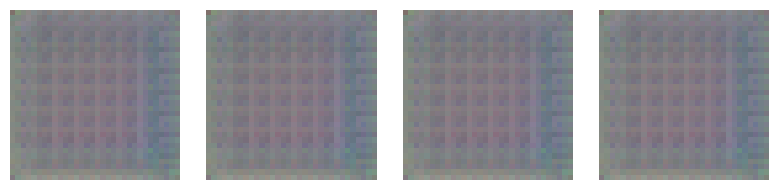

In [ ]:
# Generate sparse codes
sparse_codes = generate_sparse_codes(pixelcnn, num_images=4, device=device)

# Decode sparse codes
generated_images = decode_sparse_codes(vqvae_lista, sparse_codes)

# Visualize
visualize_generated_images(generated_images, num_images=4)

## Contrastive Approach

In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#########################################
#       Masked Convolution for PixelCNN  #
#########################################

class MaskedConv2d(nn.Conv2d):
    """
    Masked convolution prevents the filter from accessing future pixels.
    For mask type 'A', the center pixel is also masked.
    """
    def __init__(self, in_channels, out_channels, kernel_size, mask_type='A',
                 stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size,
                                           stride, padding, dilation, groups, bias)
        self.register_buffer('mask', torch.ones_like(self.weight))
        k_h, k_w = self.weight.shape[-2:]
        mid_h, mid_w = k_h // 2, k_w // 2
        mask = torch.ones_like(self.weight)
        mask[:, :, mid_h+1:, :] = 0         # Mask rows below center
        mask[:, :, mid_h, mid_w+1:] = 0       # Mask columns right of center in center row
        if mask_type == 'A':
            mask[:, :, mid_h, mid_w] = 0     # Also mask center for type A
        self.register_buffer('mask', mask)

    def forward(self, x):
        masked_weight = self.weight * self.mask
        return F.conv2d(x, masked_weight, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)

#########################################
#         Residual Block for PixelCNN    #
#########################################

class ResidualBlock(nn.Module):
    """
    A residual block with two masked convolutions (mask type 'B') and ReLU.
    """
    def __init__(self, channels, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = MaskedConv2d(channels, channels, kernel_size,
                                  mask_type='B', padding=kernel_size//2)
        self.conv2 = MaskedConv2d(channels, channels, kernel_size,
                                  mask_type='B', padding=kernel_size//2)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        residual = x
        out = self.relu(x)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out)
        return out + residual

#########################################
#       PixelCNN++ Prior (Mixture)       #
#########################################

class PixelCNNPP(nn.Module):
    """
    PixelCNN++-style prior for continuous latent codes.
    For each latent dimension d, we predict a mixture of K logistics:
      - mixture_logits: [B, K, H, W]
      - means:          [B, K, H, W]
      - log_scales:     [B, K, H, W]
    Total output channels = code_dim * K * 3.
    """
    def __init__(self, code_dim, n_mixtures=10, hidden_dim=128, n_residual=5):
        super(PixelCNNPP, self).__init__()
        self.code_dim = code_dim
        self.n_mixtures = n_mixtures
        self.out_channels = code_dim * n_mixtures * 3

        self.initial = nn.Sequential(
            MaskedConv2d(code_dim, hidden_dim, kernel_size=7, mask_type='A', padding=3),
            nn.ReLU(inplace=False)
        )
        self.residual_blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim, kernel_size=7) for _ in range(n_residual)
        ])
        self.final = nn.Sequential(
            nn.ReLU(inplace=False),
            MaskedConv2d(hidden_dim, hidden_dim, kernel_size=1, mask_type='B'),
            nn.ReLU(inplace=False),
            MaskedConv2d(hidden_dim, self.out_channels, kernel_size=1, mask_type='B')
        )

    def forward(self, x):
        """
        x: [B, code_dim, H, W]
        Returns: [B, code_dim*n_mixtures*3, H, W]
        """
        out = self.initial(x)
        out = self.residual_blocks(out)
        out = self.final(out)
        return out

    def mixture_logistic_nll(self, x, params, eps=1e-12):
        """
        x: [B, code_dim, H, W] ground-truth latent codes.
        params: [B, code_dim*n_mixtures*3, H, W] output.
        Parse the parameters into mixture_logits, means, and log_scales.
        """
        B, D, H, W = x.shape
        K = self.n_mixtures
        # Reshape params to [B, D, K*3, H, W]
        params = params.view(B, D, K*3, H, W)
        mixture_logits = params[:, :, :K]         # [B, D, K, H, W]
        means = params[:, :, K:2*K]                # [B, D, K, H, W]
        log_scales = params[:, :, 2*K:3*K]           # [B, D, K, H, W]
        log_scales = torch.clamp(log_scales, min=-7.0, max=7.0)
        scales = torch.exp(log_scales).clamp(min=1e-6)

        x = x.unsqueeze(2)  # [B, D, 1, H, W]
        log_weights = mixture_logits - torch.logsumexp(mixture_logits, dim=2, keepdim=True)
        # Logistic log-pdf: log p(x) = - log(scale) - 2*softplus(-(x-mean)/scale)
        log_pdf = -log_scales - 2.0 * F.softplus(-(x - means) / scales)
        log_mix = log_weights + log_pdf  # [B, D, K, H, W]
        log_prob = torch.logsumexp(log_mix, dim=2)  # [B, D, H, W]
        nll = -log_prob.sum(dim=1).mean()  # sum over code_dim, then mean over batch/spatial
        return nll

    def loss(self, x):
        params = self.forward(x)
        return self.mixture_logistic_nll(x, params)

    @torch.no_grad()
    def sample(self, shape, temperature=1.0, device='cuda'):
        """
        Autoregressively sample latent codes.
        shape: (B, code_dim, H, W)
        Returns: samples of shape [B, code_dim, H, W]
        """
        B, D, H, W = shape
        samples = torch.zeros(B, D, H, W, device=device)
        for h in range(H):
            for w in range(W):
                params = self.forward(samples)
                # Reshape to [B, D, n_mixtures*3, H, W]
                params = params.view(B, D, self.n_mixtures*3, H, W)
                mixture_logits = params[:, :, :self.n_mixtures, h, w]  # [B, D, K]
                means = params[:, :, self.n_mixtures:2*self.n_mixtures, h, w]  # [B, D, K]
                log_scales = params[:, :, 2*self.n_mixtures:3*self.n_mixtures, h, w]  # [B, D, K]
                log_scales = torch.clamp(log_scales, min=-7.0, max=7.0)
                scales = torch.exp(log_scales).clamp(min=1e-6) / temperature
                BD = B * D
                mix_logits_2d = mixture_logits.view(BD, self.n_mixtures) / temperature
                mix_dist = torch.distributions.Categorical(logits=mix_logits_2d)
                mix_idx = mix_dist.sample()  # [B*D]
                means_2d = means.view(BD, self.n_mixtures)
                scales_2d = scales.view(BD, self.n_mixtures)
                idx = torch.arange(BD, device=device)
                chosen_means = means_2d[idx, mix_idx]
                chosen_scales = scales_2d[idx, mix_idx]
                u = torch.rand(BD, device=device).clamp(min=1e-5, max=1-1e-5)
                logistic_sample = torch.log(u) - torch.log(1-u)
                sample_vals = chosen_means + chosen_scales * logistic_sample
                sample_vals = sample_vals.view(B, D)
                samples[:, :, h, w] = sample_vals
        return samples

#########################################
#         Contrastive Learning Head      #
#########################################

class ProjectionMLP(nn.Module):
    """
    A simple two-layer MLP to project alpha codes.
    """
    def __init__(self, in_dim=512, hidden_dim=512, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=False),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

def info_nce_loss(z1, z2, temperature=0.07):
    """
    Compute InfoNCE loss for two batches of embeddings.
    """
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    N = z1.size(0)
    z = torch.cat([z1, z2], dim=0)  # [2N, embed_dim]
    sim = torch.matmul(z, z.t()) / temperature  # [2N, 2N]
    mask = torch.eye(2*N, device=z.device).bool()
    sim.masked_fill_(mask, -9e9)
    labels = torch.arange(N, device=z.device)
    labels = torch.cat([labels + N, labels], dim=0)
    loss = F.cross_entropy(sim, labels)
    return loss

class ContrastiveSparseModel(nn.Module):
    """
    Wraps the VQ-VAE and a projection MLP.
    It extracts alpha codes from the VQ-VAE, averages spatially,
    and projects them to an embedding.
    """
    def __init__(self, vqvae_model, proj_mlp, alpha_dim=512, freeze_vqvae=True):
        super().__init__()
        self.vqvae = vqvae_model
        self.proj = proj_mlp
        self.alpha_dim = alpha_dim
        if freeze_vqvae:
            for param in self.vqvae.parameters():
                param.requires_grad = False

    def forward(self, x):
        # x: [B, C, H, W]
        with torch.no_grad() if all(not p.requires_grad for p in self.vqvae.parameters()) else torch.enable_grad():
            z_e = self.vqvae.encode(x)
            _, alpha, _ = self.vqvae.quantize(z_e)
            B, C, H, W = z_e.shape
            if alpha.dim() == 2:
                alpha = alpha.view(B, H, W, self.alpha_dim)
            alpha_flat = alpha.view(B, -1, self.alpha_dim)
            alpha_mean = alpha_flat.mean(dim=1)  # [B, alpha_dim]
        z = self.proj(alpha_mean)
        return z

def train_contrastive_sparse(model, train_loader, num_epochs=10, lr=1e-3, temperature=0.07, device="cuda"):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        count = 0
        pbar = tqdm(train_loader, desc=f"Contrastive Epoch {epoch+1}/{num_epochs}")
        for (img1, img2), _ in pbar:
            img1 = img1.to(device)
            img2 = img2.to(device)
            z1 = model(img1)
            z2 = model(img2)
            loss = info_nce_loss(z1, z2, temperature=temperature)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * img1.size(0)
            count += img1.size(0)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        avg_loss = total_loss / count
        print(f"Contrastive Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

#########################################
#      Contrastive Dataset for CIFAR10   #
#########################################

class ContrastiveCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root, train=True, transform1=None, transform2=None, download=False):
        super().__init__(root=root, train=train, download=download)
        self.transform1 = transform1
        self.transform2 = transform2

    def __getitem__(self, index):
        img, label = self.data[index], self.targets[index]
        img = torchvision.transforms.functional.to_pil_image(img)
        view1 = self.transform1(img) if self.transform1 is not None else T.ToTensor()(img)
        view2 = self.transform2(img) if self.transform2 is not None else T.ToTensor()(img)
        return (view1, view2), label

#########################################
#          Sampling & Decoding           #
#########################################

@torch.no_grad()
def sample_and_decode_pixelcnnpp(model, vqvae_model, num_samples=16, code_dim=512, latent_shape=(8,8),
                                 temperature=0.8, device='cuda'):
    sample_shape = (num_samples, code_dim, latent_shape[0], latent_shape[1])
    alpha_samples = model.sample(sample_shape, temperature=temperature, device=device)
    B, D, H, W = alpha_samples.shape
    alpha_flat = alpha_samples.permute(0, 2, 3, 1).reshape(-1, D)
    z_q_flat = alpha_flat @ trained_model.dictionary.D  # [B*H*W, embedding_dim]
    z_q = z_q_flat.view(B, H, W, trained_model.embedding_dim).permute(0, 3, 1, 2)
    images = vqvae_model.decode(z_q)
    images = torch.clamp(images, -1, 1)
    images = (images + 1) / 2
    return images

def visualize_images(images, grid_size=(4,4), save_path=None):
    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(grid_size[1]*2, grid_size[0]*2))
    axes = axes.flatten()
    for i, img in enumerate(images):
        if i < len(axes):
            axes[i].imshow(np.clip(img, 0, 1))
            axes[i].axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

#########################################
#   Training PixelCNN++ Prior (BPD)      #
#########################################

def train_pixelcnnpp(model, vqvae_model, train_loader, num_epochs=5, lr=1e-4, device='cuda'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    vqvae_model.to(device)
    vqvae_model.eval()
    for epoch in range(num_epochs):
        model.train()
        total_nll = 0.0
        total_bpd = 0.0
        count = 0
        pbar = tqdm(train_loader, desc=f"PixelCNN++ Epoch {epoch+1}/{num_epochs}")
        for data, _ in pbar:
            data = data.to(device)
            with torch.no_grad():
                z_e = trained_model.encode(data)
                _, alpha, _ = trained_model.quantize(z_e)
                B, C, H, W = z_e.shape
                if alpha.dim() == 2:
                    alpha = alpha.view(B, H, W, -1)
                real_codes = alpha.permute(0, 3, 1, 2).contiguous()
            nll = model.loss(real_codes)
            optimizer.zero_grad()
            nll.backward()
            optimizer.step()
            code_dim = real_codes.shape[1]
            bpd = nll.item() / (math.log(2) * code_dim * H * W)
            total_nll += nll.item() * data.size(0)
            total_bpd += bpd * data.size(0)
            count += data.size(0)
            pbar.set_postfix({"NLL": f"{nll.item():.4f}", "BPD": f"{bpd:.4f}"})
        avg_nll = total_nll / count
        avg_bpd = total_bpd / count
        print(f"Epoch {epoch+1}/{num_epochs}, Avg NLL: {avg_nll:.4f}, Avg BPD: {avg_bpd:.4f}")
    return model

#########################################
#             Main Script              #
#########################################

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Assume trained_model is your pre-trained VQ-VAE, already loaded.
    # It must implement encode, quantize, decode, and have attributes:
    #   dictionary.D (shape [code_dim, embedding_dim]) and embedding_dim.
    # Here, trained_model is assumed to be defined.
    trained_model = trained_model  # pre-loaded variable
    trained_model = trained_model.to(device)
    trained_model.eval()

    # ------------------ Phase A: Contrastive Learning ------------------
    transform_view1 = T.Compose([
        T.RandomResizedCrop(32, scale=(0.5, 1.0)),
        T.RandomHorizontalFlip(),
        T.ToTensor()
    ])
    transform_view2 = T.Compose([
        T.RandomResizedCrop(32, scale=(0.5, 1.0)),
        T.RandomHorizontalFlip(),
        T.ToTensor()
    ])
    contrastive_dataset = ContrastiveCIFAR10(root="./data", train=True, download=True,
                                             transform1=transform_view1, transform2=transform_view2)
    contrastive_loader = DataLoader(contrastive_dataset, batch_size=64, shuffle=True, num_workers=2)

    proj_mlp = ProjectionMLP(in_dim=trained_model.dictionary.D.shape[0], hidden_dim=512, out_dim=128)
    contrastive_model = ContrastiveSparseModel(trained_model, proj_mlp,
                                                 alpha_dim=trained_model.dictionary.D.shape[0],
                                                 freeze_vqvae=True)
    print("Training contrastive model on alpha codes...")
    train_contrastive_sparse(contrastive_model, contrastive_loader,
                             num_epochs=1, lr=1e-3, temperature=0.07, device=device)

    # ------------------ Phase B: PixelCNN++ Prior ------------------
    transform_standard = T.Compose([
        T.ToTensor(),
        T.Resize((32, 32))
    ])
    cifar_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True,
                                                   transform=transform_standard)
    train_loader = DataLoader(cifar_dataset, batch_size=64, shuffle=True, num_workers=4)

    code_dim = trained_model.dictionary.D.shape[0]  # e.g. 512
    pixelcnnpp = PixelCNNPP(code_dim=code_dim, n_mixtures=10, hidden_dim=128, n_residual=5).to(device)
    print("Training PixelCNN++ prior on alpha codes...")
    pixelcnnpp = train_pixelcnnpp(pixelcnnpp, trained_model, train_loader,
                                  num_epochs=5, lr=1e-4, device=device)

    # ------------------ Sampling & Decoding ------------------
    print("Sampling from PixelCNN++ prior and decoding...")
    samples = sample_and_decode_pixelcnnpp(pixelcnnpp, trained_model, num_samples=16,
                                            code_dim=code_dim, latent_shape=(8,8),
                                            temperature=0.8, device=device)
    visualize_images(samples, grid_size=(4,4), save_path="pixelcnnpp_alpha_samples.png")

Using device: cuda
Files already downloaded and verified
Training contrastive model on alpha codes...


Contrastive Epoch 1/1: 100%|██████████| 782/782 [02:16<00:00,  5.73it/s, loss=0.0996]


Contrastive Epoch 1/1, Avg Loss: 0.5804
Files already downloaded and verified
Training PixelCNN++ prior on alpha codes...


PixelCNN++ Epoch 1/5:  47%|████▋     | 364/782 [00:10<00:12, 33.92it/s, NLL=-3583.9097, BPD=-0.1578]


KeyboardInterrupt: 

In [ ]:
@torch.no_grad()
def sample_and_decode_pixelcnnpp(model, vqvae_model, num_samples=16, code_dim=512, latent_shape=(8,8),
                                 temperature=0.8, device='cuda'):
    """
    Autoregressively sample latent codes using the PixelCNN++ prior,
    then decode them with the VQ-VAE decoder.
    """
    # Sample latent codes from the prior
    sample_shape = (num_samples, code_dim, latent_shape[0], latent_shape[1])
    alpha_samples = model.sample(sample_shape, temperature=temperature, device=device)

    # Map the latent codes to the VQ-VAE embedding space using the dictionary
    B, D, H, W = alpha_samples.shape
    # Rearrange so that the last dimension is the latent code dimension
    alpha_flat = alpha_samples.permute(0, 2, 3, 1).reshape(-1, D)
    # Use the dictionary from the vqvae_model (not a global variable)
    z_q_flat = alpha_flat @ vqvae_model.dictionary.D  # [B*H*W, embedding_dim]
    z_q = z_q_flat.view(B, H, W, vqvae_model.embedding_dim).permute(0, 3, 1, 2)

    # Decode the latent codes into images and map values from [-1,1] to [0,1]
    images = vqvae_model.decode(z_q)
    images = torch.clamp(images, -1, 1)
    images = (images + 1) / 2
    return images


@torch.no_grad()
def test_vqvae_decoder(vqvae_model, dataloader, device='cuda'):
    """
    Test the VQ-VAE decoder using latent codes extracted from real images.
    This function helps verify that the decoder and dictionary mapping are working as expected.
    """
    for data, _ in dataloader:
        data = data.to(device)
        # Encode and quantize real data
        z_e = vqvae_model.encode(data)
        _, alpha, _ = vqvae_model.quantize(z_e)
        B, C, H, W = z_e.shape
        if alpha.dim() == 2:
            alpha = alpha.view(B, H, W, -1)
        # Rearrange alpha codes to [B, code_dim, H, W]
        real_codes = alpha.permute(0, 3, 1, 2).contiguous()
        # Decode the real latent codes
        images = vqvae_model.decode(real_codes)
        images = torch.clamp(images, -1, 1)
        images = (images + 1) / 2
        visualize_images(images, grid_size=(4,4))
        break  # Display one batch only

# Example usage in your main training script:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Assume trained_model is your pre-trained VQ-VAE, already loaded and defined.
    # Make sure that trained_model has methods: encode, quantize, decode,
    # and attributes: dictionary.D (shape [code_dim, embedding_dim]) and embedding_dim.
    trained_model = trained_model.to(device)
    trained_model.eval()

    # --- (Contrastive learning and PixelCNN++ training code remains as before) ---
    # After training the PixelCNN++ prior, you can test the VQ-VAE decoder:
    print("Testing VQ-VAE decoder on real latent codes...")
    # Here, we reuse your CIFAR10 dataloader (or create a new one) for testing
    transform_standard = T.Compose([
        T.ToTensor(),
        T.Resize((32, 32))
    ])
    test_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True,
                                                transform=transform_standard)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)
    test_vqvae_decoder(trained_model, test_loader, device=device)

    # Now, sample from the PixelCNN++ prior and decode the samples
    print("Sampling from PixelCNN++ prior and decoding...")
    # Ensure code_dim matches your VQ-VAE's latent space dimension (e.g., 512)
    samples = sample_and_decode_pixelcnnpp(pixelcnnpp, trained_model, num_samples=16,
                                            code_dim=trained_model.dictionary.D.shape[0],
                                            latent_shape=(8,8),
                                            temperature=0.8, device=device)
    visualize_images(samples, grid_size=(4,4), save_path="pixelcnnpp_alpha_samples.png")

Using device: cuda
Testing VQ-VAE decoder on real latent codes...
Files already downloaded and verified


RuntimeError: Given transposed=1, weight of size [64, 256, 4, 4], expected input[64, 512, 8, 8] to have 64 channels, but got 512 channels instead